### *Text-Driven Salary Bracket Prediction with ML & Text Analytics*

This assignment involves building and testing classification models to predict salaries from the text contained in the job descriptions. The data for this assignment can be found at http://www.kaggle.com/c/job-salary-prediction

* Randomly select 2500 data points from the training dataset (“Train_rev1.csv”) for ease of analysis. Then split the 2500 data points into training (80%) and test (20%) sets.
* You will create classification models to predict high (75th percentile and above) or low (below 75th percentile) salary from the text contained in the job descriptions.
* Use the Naïve Bayes classifier.

**Question 1:**

* Build a classification model with text (full job description) as the predictor. What is the accuracy of your model? Show the confusion matrix. Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary.

**Question 2:**

* If you wanted to increase the accuracy of the model above, how can you accomplish this using the dataset you have?

#### Importing Relevant Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys
import re
import gc
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

#### Loading the Data

In [ ]:
data = pd.read_csv("C:/Users/mehri/Downloads/Train_rev1.csv")
data = data.sample(2500, random_state = 42) # Randomly selecting 2500 samples from data
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
30390,68062598,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West,South West London,NaN,permanent,BMS Sales Specialists,Sales Jobs,"22000 - 25000 per annum + Car,Mobile,Pension,L...",23500,totaljobs.com
108709,69622111,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,Newtownabbey,full_time,NaN,Regional Recruitment Services,Healthcare & Nursing Jobs,12.00/Hour,23040,staffnurse.com
13924,66664026,Community Fundraising Manager,This dynamic international development charity...,London,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,33300 - 36400 per annum,34850,Third Sector Jobs
154606,71015241,Conveyancing Executive,Large regional law firm require a residential ...,Hampshire,Hampshire,full_time,permanent,PTP Consulting,Legal Jobs,"From 18,000 to 27,000 per year",22500,TotallyLegal
172891,71428553,Investment Compliance Analyst,This individual will work closely with the bus...,London South East,South East London,NaN,permanent,Michael Page Financial Services,Accounting & Finance Jobs,50000 to 60000 per annum,55000,totaljobs.com


In [ ]:
# Assigning whether we are above or below 75th Percentile
data['Percentile'] = data['SalaryNormalized'].rank(pct = True)
data.loc[data['Percentile'] > 0.75, 'Target'] = 'Above'
data.loc[data['Percentile'] < 0.75, 'Target'] = 'Below'
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Percentile,Target
30390,68062598,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West,South West London,NaN,permanent,BMS Sales Specialists,Sales Jobs,"22000 - 25000 per annum + Car,Mobile,Pension,L...",23500,totaljobs.com,0.3166,Below
108709,69622111,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,Newtownabbey,full_time,NaN,Regional Recruitment Services,Healthcare & Nursing Jobs,12.00/Hour,23040,staffnurse.com,0.3094,Below
13924,66664026,Community Fundraising Manager,This dynamic international development charity...,London,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,33300 - 36400 per annum,34850,Third Sector Jobs,0.5944,Below
154606,71015241,Conveyancing Executive,Large regional law firm require a residential ...,Hampshire,Hampshire,full_time,permanent,PTP Consulting,Legal Jobs,"From 18,000 to 27,000 per year",22500,TotallyLegal,0.2882,Below
172891,71428553,Investment Compliance Analyst,This individual will work closely with the bus...,London South East,South East London,NaN,permanent,Michael Page Financial Services,Accounting & Finance Jobs,50000 to 60000 per annum,55000,totaljobs.com,0.8908,Above


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### I. Constructing a Text-Based Classification Model Using "FullDescription" as a Predictor

A Naïve Bayes classifier was trained using job descriptions to predict salary categories (high or low). The job description text data was preprocessed by tokenizing, removing stopwords, and stemming before being vectorized using TF-IDF (Term Frequency-Inverse Document Frequency).

**Model Accuracy & Confusion Matrix:**

The model's accuracy on the test set is approximately 74.2%, as indicated by the output Accuracy: 0.742. The confusion matrix displayed suggests that while the model is quite good at predicting low salaries (with a true positive rate of 371), it failed to predict high salaries correctly (0 true positives for high salary).

**Top 10 Words Indicative of High and Low Salary:**

* The top 10 words most indicative of a high salary, excluding stopwords, are: 'design', 'engine', 'client', 'team', 'work', 'experi', 'busi', 'project', 'develop', and 'manag'.
* The top 10 words most indicative of a low salary are: 'busi', 'custom', 'client', 'servic', 'role', 'develop', 'experi', 'sale', 'work', and 'manag'.

These words provide insight into the language used in job descriptions that correlate with salary levels. It's important to note that some words appear in both lists, which could be due to different contexts in which they are used or the presence of other words in the job descriptions that when combined with these can indicate salary levels.

**Classification Report:**

The classification report shows a precision of 0.74 and recall of 1.00 for the 'Low Salary' class, indicating that the model is consistent in predicting low salaries but at the cost of not predicting high salaries at all, which is evident from the 0.00 precision and recall for the 'High Salary' class.

* From the confusion matrix visualization and classification report below, it is clear that the model is biased towards predicting the majority class (low salary). This could be due to an imbalance in the dataset, where there are more low salary examples than high salary ones. We might consider techniques to balance the dataset or use different performance metrics that take the class imbalance into account, such as the F1-score or the area under the receiver operating characteristic curve (AUC-ROC).

* Additionally, the words 'experi' and 'busi' seem to be stemmed forms of 'experience' and 'business'. The stemming process reduces words to their root form, which sometimes might not represent an actual word. It's important to consider the impact of stemming on the interpretation of the most indicative words. More advanced techniques like lemmatization could provide better results as they reduce words to their dictionary forms.

---
Lastly, to improve the model's ability to predict high salary postings, we might want to explore more complex models, feature engineering, or even deep learning techniques if the dataset is sufficiently large (*Refer to Question 2*).

#### Classification Model

In [ ]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize, remove stopwords, and stem
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    stemmed = [stemmer.stem(word.lower()) for word in tokens]
    return ' '.join(stemmed)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Preprocess the job descriptions
data['ProcessedDescription'] = data['FullDescription'].apply(preprocess_text)

In [ ]:
# Feature extraction
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['ProcessedDescription'])
y = data['Target'].apply(lambda x: 1 if x == 'Above' else 0)  # Convert the target to a binary format

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Train the Naïve Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
# Display accuracy and confusion matrix
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.742
Confusion Matrix:
 [[371   0]
 [129   0]]


In [ ]:
# Identify indicative features (words)
feature_names = vectorizer.get_feature_names_out()
high_salary_indices = model.feature_log_prob_[1].argsort()[-10:]
low_salary_indices = model.feature_log_prob_[0].argsort()[-10:]

In [ ]:
# Print the top 10 indicative words for high salary and low salary
print("Top 10 words indicative of high salary:")
for index in high_salary_indices:
    print(feature_names[index])

Top 10 words indicative of high salary:
design
engin
client
team
work
experi
busi
project
develop
manag


In [ ]:
print("\nTop 10 words indicative of low salary:")
for index in low_salary_indices:
    print(feature_names[index])


Top 10 words indicative of low salary:
busi
custom
client
servic
role
develop
experi
sale
work
manag


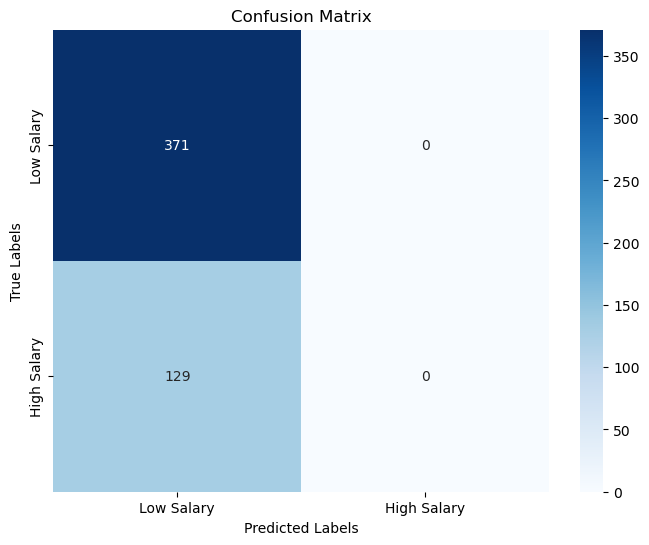

In [ ]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Low Salary', 'High Salary'])
ax.yaxis.set_ticklabels(['Low Salary', 'High Salary'])
plt.show()

In [ ]:
from sklearn.metrics import classification_report

#'y_test' are the true labels and 'y_pred' are the predicted labels from the classifier
report = classification_report(y_test, y_pred, target_names=['Low Salary', 'High Salary'])

print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

  Low Salary       0.74      1.00      0.85       371
 High Salary       0.00      0.00      0.00       129

    accuracy                           0.74       500
   macro avg       0.37      0.50      0.43       500
weighted avg       0.55      0.74      0.63       500



C:\Users\mehri\ana\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mehri\ana\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mehri\ana\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


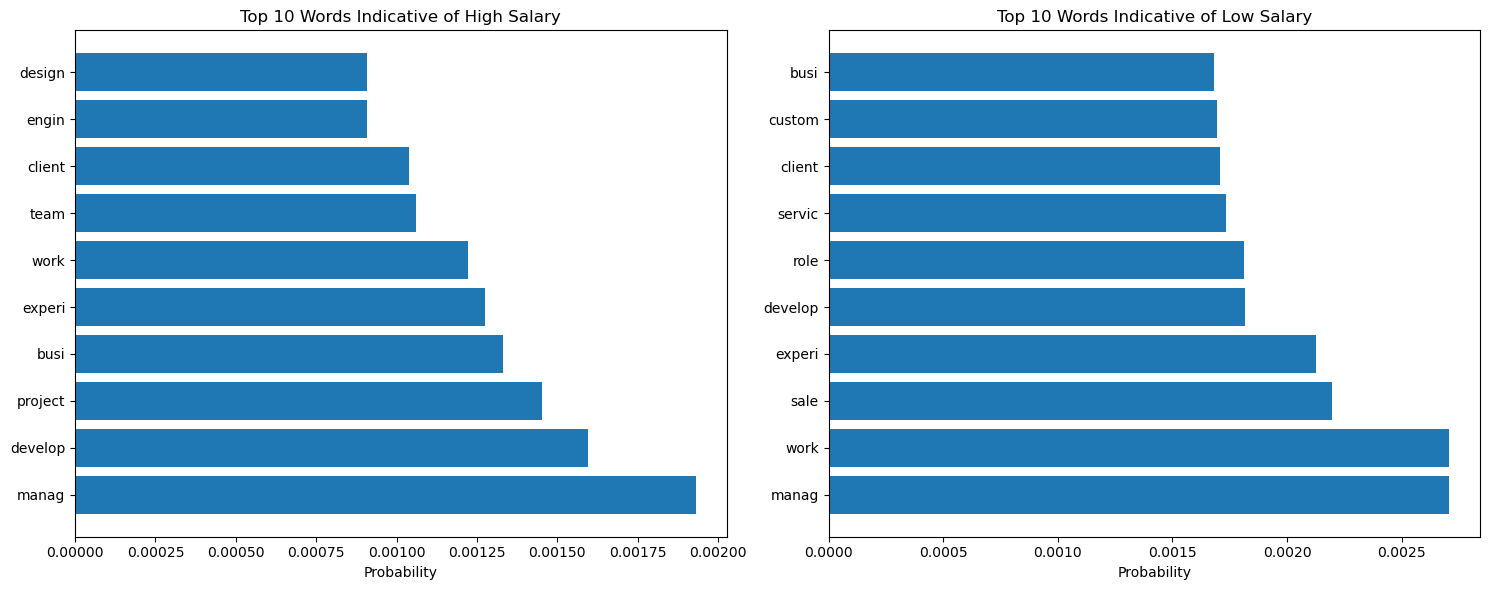

In [ ]:
# For the visualization, we need the feature log probabilities for the words:
high_salary_log_probs = model.feature_log_prob_[1, high_salary_indices]
low_salary_log_probs = model.feature_log_prob_[0, low_salary_indices]

# Get the words for high and low salaries
high_salary_words = [feature_names[i] for i in high_salary_indices]
low_salary_words = [feature_names[i] for i in low_salary_indices]

# Set up the figure size and subplots
plt.figure(figsize=(15, 6))

# High salary words plot
plt.subplot(1, 2, 1)
plt.barh(high_salary_words, np.exp(high_salary_log_probs))
plt.xlabel('Probability')
plt.title('Top 10 Words Indicative of High Salary')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability on top

# Low salary words plot
plt.subplot(1, 2, 2)
plt.barh(low_salary_words, np.exp(low_salary_log_probs))
plt.xlabel('Probability')
plt.title('Top 10 Words Indicative of Low Salary')
plt.gca().invert_yaxis()

# Show plot with tight layout
plt.tight_layout()
plt.show()

### II. Enhancing Model Accuracy: Strategies for Improving Classification Performance

To further enhance the accuracy of the model, we can explore additional strategies and considerations:

1. **Feature engineering**: Besides the existing text preprocessing techniques, we can delve deeper into feature engineering. This involves extracting more meaningful features from the text data, such as word embeddings or word frequencies, which can provide richer representations of the job descriptions.

2. **Model selection**: While Naive Bayes is a popular choice for text classification tasks, it's beneficial to experiment with other algorithms such as Support Vector Machines (SVM), Random Forests, or Gradient Boosting Machines (GBM). Each algorithm has its strengths and weaknesses, and finding the most suitable one for our specific dataset can lead to improved accuracy.

3. **Hyperparameter tuning**: Optimizing the hyperparameters of the chosen algorithm can significantly impact the model's performance. Techniques like grid search or randomized search can help us find the best combination of hyperparameters, resulting in better accuracy.

4. **Ensemble/Stacked methods**: Combining multiple models using ensemble techniques like bagging (e.g., Random Forest) or boosting (e.g., AdaBoost, XGBoost) can often lead to higher accuracy than using a single model. Ensemble methods leverage the diversity of multiple models to make more accurate predictions.

5. **Cross-validation**: Utilizing cross-validation techniques such as k-fold cross-validation ensures that the model's performance is robust and generalizable. By evaluating the model on different subsets of the data, we can obtain a more accurate estimate of its performance and identify any potential overfitting issues.

6. **Error analysis**: Conducting thorough error analysis can provide valuable insights into the shortcomings of the model. By examining misclassified instances, we can identify patterns or common themes that the model struggles with and take corrective actions, such as refining the feature engineering process or addressing class imbalances.

By incorporating these strategies and conducting comprehensive experimentation, we can iteratively improve the accuracy of the classification model and optimize its performance for predicting job salaries based on text data.

### Reflective Learning

Throughout this assignment, I uncovered the complexities of text-based predictive modeling. I not only refined my understanding of machine learning principles but also gained practical, hands-on experience with data preprocessing, model tuning, and evaluation. The lessons learned have significantly enhanced my analytical journey and have provided me with invaluable insights into the challenges and considerations of building robust classification models.

Kety Takeaways:

- Mastered the art of data selection and preprocessing, learning the impact of quality data on model performance.
  
- Gained proficiency in feature engineering, applying how different text representation techniques like TF-IDF and word
  
- Learned to critically analyze model performance metrics, going beyond mere accuracy to consider precision, recall, and F1-score, ensuring a balanced perspective on model efficacy.